# Fitting py3DCORE_h4c

In [1]:
%load_ext autoreload

%autoreload 2

import heliosat
import logging
import datetime
import numpy as np
import os
import pickle
import py3dcore_h4c as py3dcore_h4c
import matplotlib.pyplot as plt
import shutil
import pandas as pds
import event as evt

/home/hruedisser/core91/lib64/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
from heliosat.util import sanitize_dt

logging.basicConfig(level=logging.INFO)
logging.getLogger("heliosat.spice").setLevel("WARNING")
logging.getLogger("heliosat.spacecraft").setLevel("WARNING")

## ICMECAT

We first read the catalog and save all events in lists.

In [3]:
wincat,stacat,stbcat,pspcat,solocat,bepicat,ulycat,messcat,vexcat = evt.get_cat()

i1au = wincat + stacat + stbcat
print('ICMECAT events near 1 AU',len(i1au))

got wincat: 448
got stacat: 258
got stbcat: 150
got pspcat: 35
got solocat: 34
got bepicat: 32
got ulycat: 0
got messcat: 0
got vexcat: 93
ICMECAT events near 1 AU 856


We now choose a specific event we want to fit.

In [4]:
winevent = evt.findevent(wincat, year=2022,month=2,day=3)

print('Start of event: '+str(winevent[0].begin))
print('Start of MC: '+str(winevent[0].cloud))
print('End of event: '+str(winevent[0].end))

Number of events in time interval: 1
Start of event: 2022-02-03 22:52:00+00:00
Start of MC: 2022-02-04 04:12:00+00:00
End of event: 2022-02-04 13:52:00+00:00


We set the launchtime for the CME, t_launch (as observed), and two points in time (t_s and t_e), that lie outside of our fitting range. These function as reference points to check, whether an ensemble is actually hitting our spacecraft within the time window. Furthermore, we set fitting points, t, to which the flux rope model will be fitted.

In [5]:
#t_launch = winevent[0].begin-datetime.timedelta(days=4)

t_launch = datetime.datetime(2022, 1, 29, 12,tzinfo=datetime.timezone.utc)

t_s_wind = datetime.datetime(2022, 2, 2, 18, tzinfo=datetime.timezone.utc)
t_e_wind = datetime.datetime(2022, 2, 3, 14,tzinfo=datetime.timezone.utc)

t_wind = [
    datetime.datetime(2022, 2, 3,2, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 2, 3,4, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 2, 3,6, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 2, 3,8, tzinfo=datetime.timezone.utc)
]

Restraining the initial values for the ensemble members leads to more efficient fitting.

    Model Parameters
    ================
        For this specific model there are a total of 14 initial parameters which are as follows:
        0: t_i          time offset
        1: lon          longitude
        2: lat          latitude
        3: inc          inclination

        4: dia          cross section diameter at 1 AU
        5: delta        cross section aspect ratio

        6: r0           initial cme radius
        7: v0           initial cme velocity
        8: T            T factor (related to the twist)

        9: n_a          expansion rate
        10: n_b         magnetic field decay rate

        11: b           magnetic field strength at center at 1AU
        12: bg_d        solar wind background drag coefficient
        13: bg_v        solar wind background speed

        There are 4 state parameters which are as follows:
        0: v_t          current velocity
        1: rho_0        torus major radius
        2: rho_1        torus minor radius
        3: b_t          magnetic field strength at center

In [6]:
model_kwargs = {
    "ensemble_size": int(2**16), #2**17
    "iparams": {
       "cme_longitude": {
           "maximum": 10,
           "minimum": -15
       },
       "cme_latitude": {
           "maximum": 15,
           "minimum": -25
       },
       "cme_inclination": {
           "maximum": 90,
           "minimum": 0
       }, 
        "cme_launch_velocity": {
            "maximum": 900,
            "minimum": 500
        },
        "cme_launch_radius": {
            "default_value": 20
        }
    }
}

In [7]:
#"cme_launch_offset": {
#    "distribution": "uniform",
#    "maximum": 3600*24,
#    "minimum": -3600*24
#}

In [8]:
output_test = 'out_example_fitting/'

fitter = py3dcore_h4c.ABC_SMC()
fitter.initialize(t_launch, py3dcore_h4c.ToroidalModel, model_kwargs)
fitter.add_observer("WIND", t_wind, t_s_wind, t_e_wind)

# set jobs=8, workers=8, to avoid using all CPU cores

fitter.run(ensemble_size=512, reference_frame="HEEQ", sampling_freq=3600, output=output_test) 

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


INFO:py3dcore_h4c.fitter.abc_smc:running iteration 0
INFO:py3dcore_h4c.fitter.abc_smc:initial eps_init = [1.2101618]
INFO:py3dcore_h4c.fitter.abc_smc:starting simulations
INFO:py3dcore_h4c.fitter.abc_smc:step 0:0 with (1431/512) particles
INFO:py3dcore_h4c.fitter.abc_smc:setting new eps: [1.2101618] => [0.90530723]
INFO:py3dcore_h4c.fitter.abc_smc:step 0 done, 512 particles, 0.52M runs in 11.24 seconds, (total: 00h 00m 11s)
INFO:py3dcore_h4c.fitter.abc_smc:running iteration 1
INFO:py3dcore_h4c.fitter.abc_smc:starting simulations
INFO:py3dcore_h4c.fitter.abc_smc:step 1:0 with (5034/512) particles
INFO:py3dcore_h4c.fitter.abc_smc:setting new eps: [0.90530723] => [0.69144411]
INFO:py3dcore_h4c.fitter.abc_smc:step 1 done, 512 particles, 0.52M runs in 22.84 seconds, (total: 00h 00m 34s)
INFO:py3dcore_h4c.fitter.abc_smc:running iteration 2
INFO:py3dcore_h4c.fitter.abc_smc:starting simulations
INFO:py3dcore_h4c.fitter.abc_smc:step 2:0 with (3444/512) particles
INFO:py3dcore_h4c.fitter.abc_smc

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


now that the fitting is completed, we look at the results.

In [9]:
# Get the list of all files and directories
path = output_test
dir_list = sorted(os.listdir(path))
 
print("Files and directories in '", path, "' :")
 
# prints all files
print(dir_list)

resultpath = path + dir_list[-1]
resultpath2 = path + dir_list[-2]
print(resultpath)

Files and directories in ' out_example_fitting/ ' :
['00.pickle', '01.pickle', '02.pickle', '03.pickle', '04.pickle', '05.pickle', '06.pickle', '07.pickle', '08.pickle', '09.pickle']
out_example_fitting/09.pickle


/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:58: RuntimeWarning: Mean of empty slice
  b_m = np.nanmean(ensemble, axis=1)
/home/hruedisser/core91/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:64: RuntimeWarning: Mean of empty slice
  b_tm = np.nanmean(b_t, axis=1)


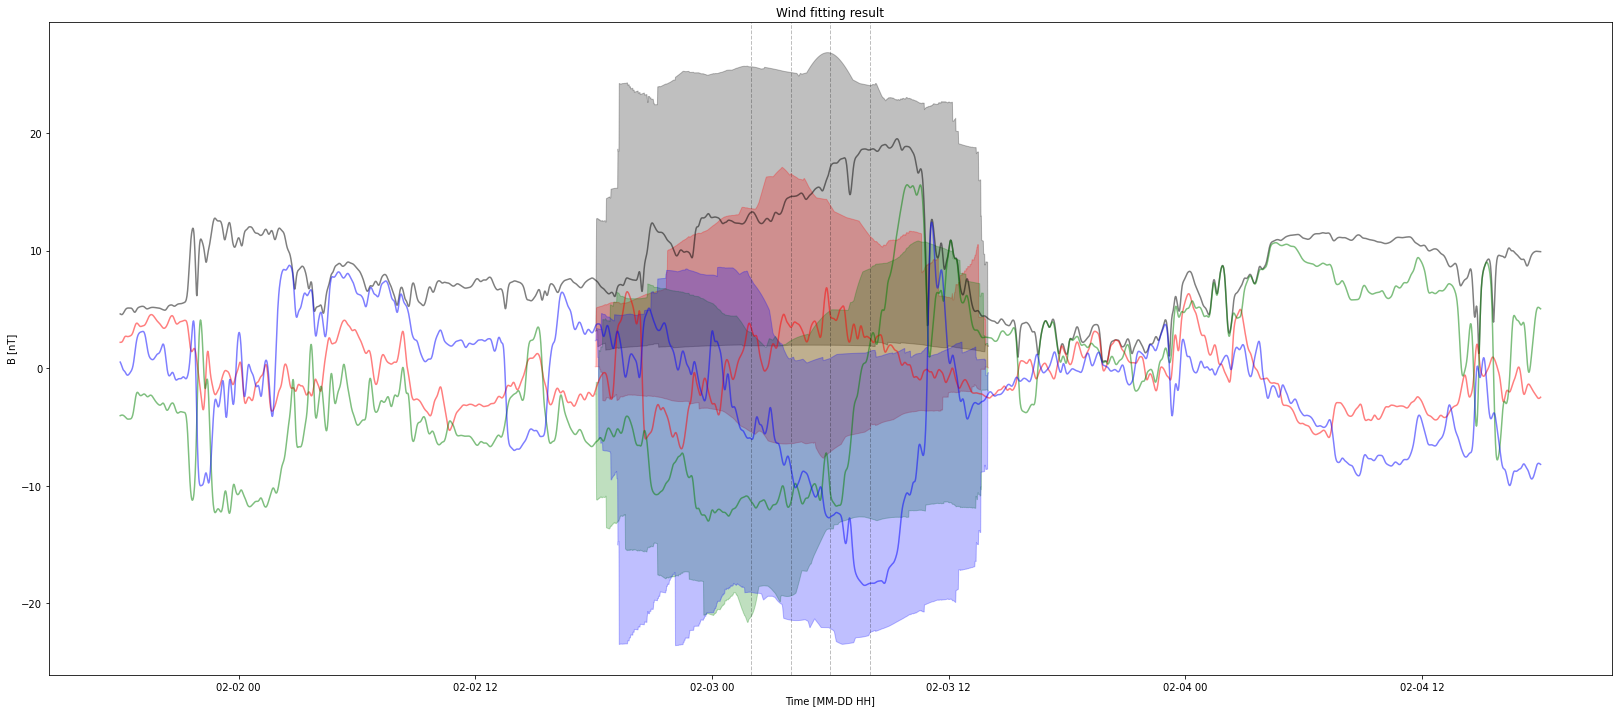

/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:58: RuntimeWarning: Mean of empty slice
  b_m = np.nanmean(ensemble, axis=1)
/home/hruedisser/core91/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:64: RuntimeWarning: Mean of empty slice
  b_tm = np.nanmean(b_t, axis=1)


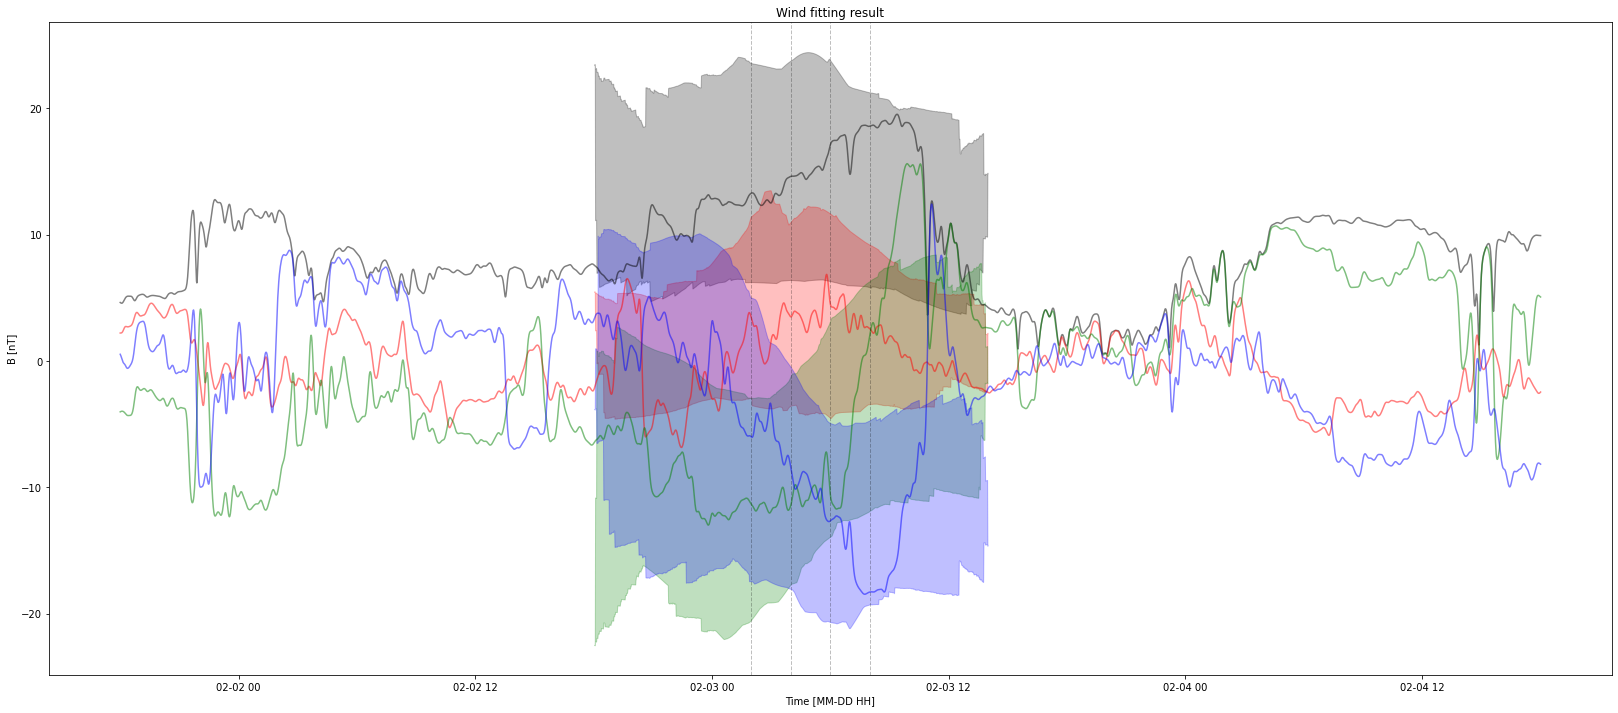

/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:58: RuntimeWarning: Mean of empty slice
  b_m = np.nanmean(ensemble, axis=1)
/home/hruedisser/core91/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:64: RuntimeWarning: Mean of empty slice
  b_tm = np.nanmean(b_t, axis=1)


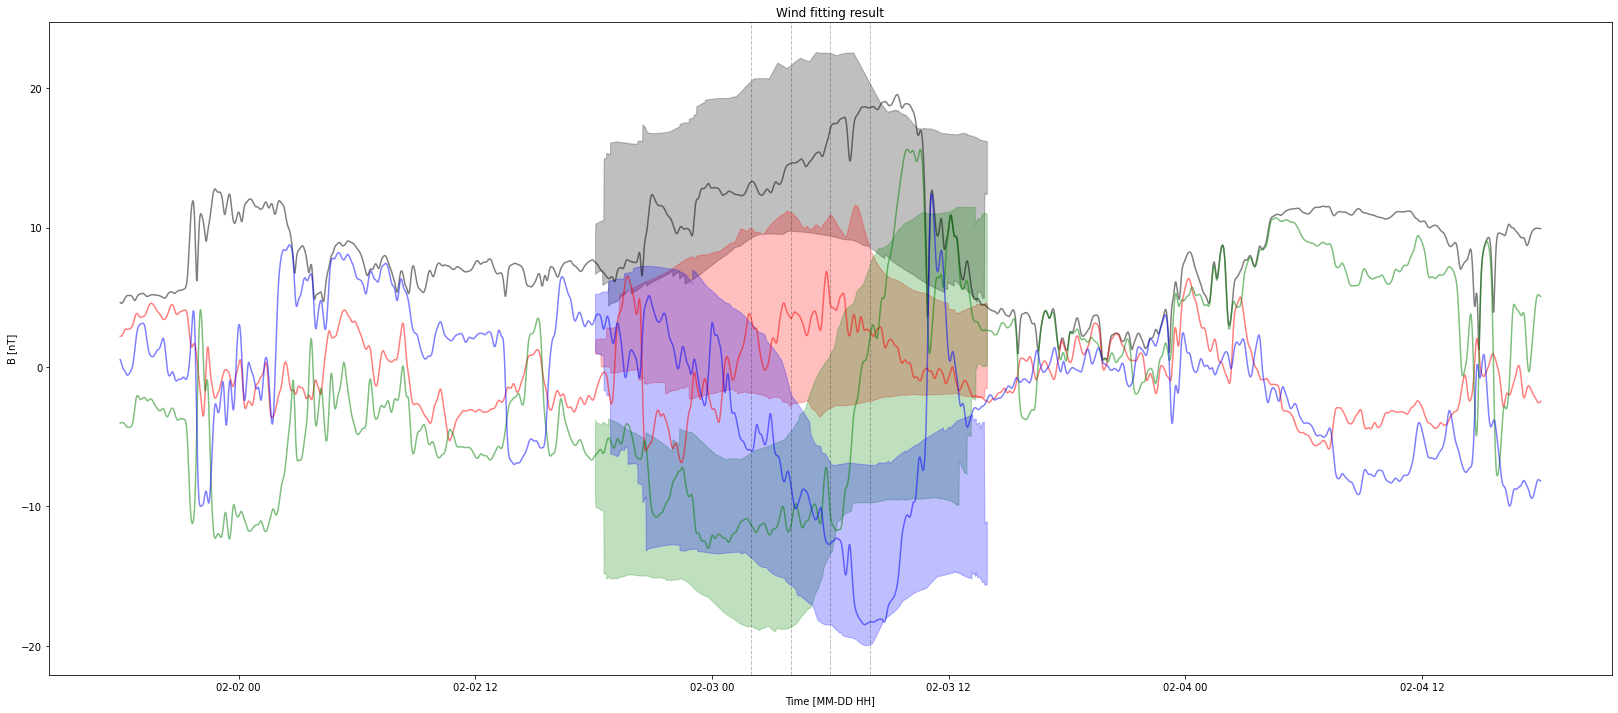

/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:58: RuntimeWarning: Mean of empty slice
  b_m = np.nanmean(ensemble, axis=1)
/home/hruedisser/core91/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:64: RuntimeWarning: Mean of empty slice
  b_tm = np.nanmean(b_t, axis=1)


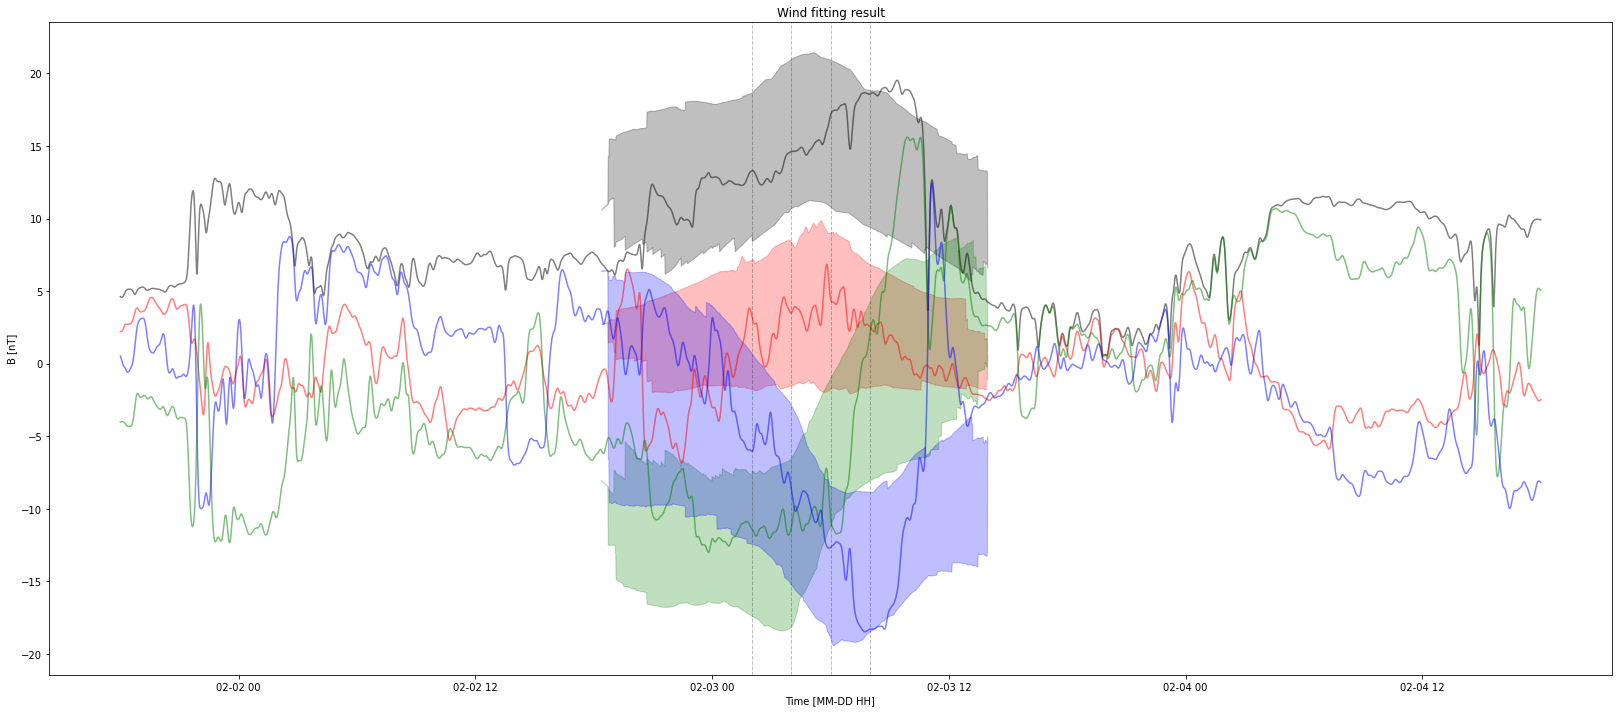

/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:58: RuntimeWarning: Mean of empty slice
  b_m = np.nanmean(ensemble, axis=1)
/home/hruedisser/core91/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:64: RuntimeWarning: Mean of empty slice
  b_tm = np.nanmean(b_t, axis=1)


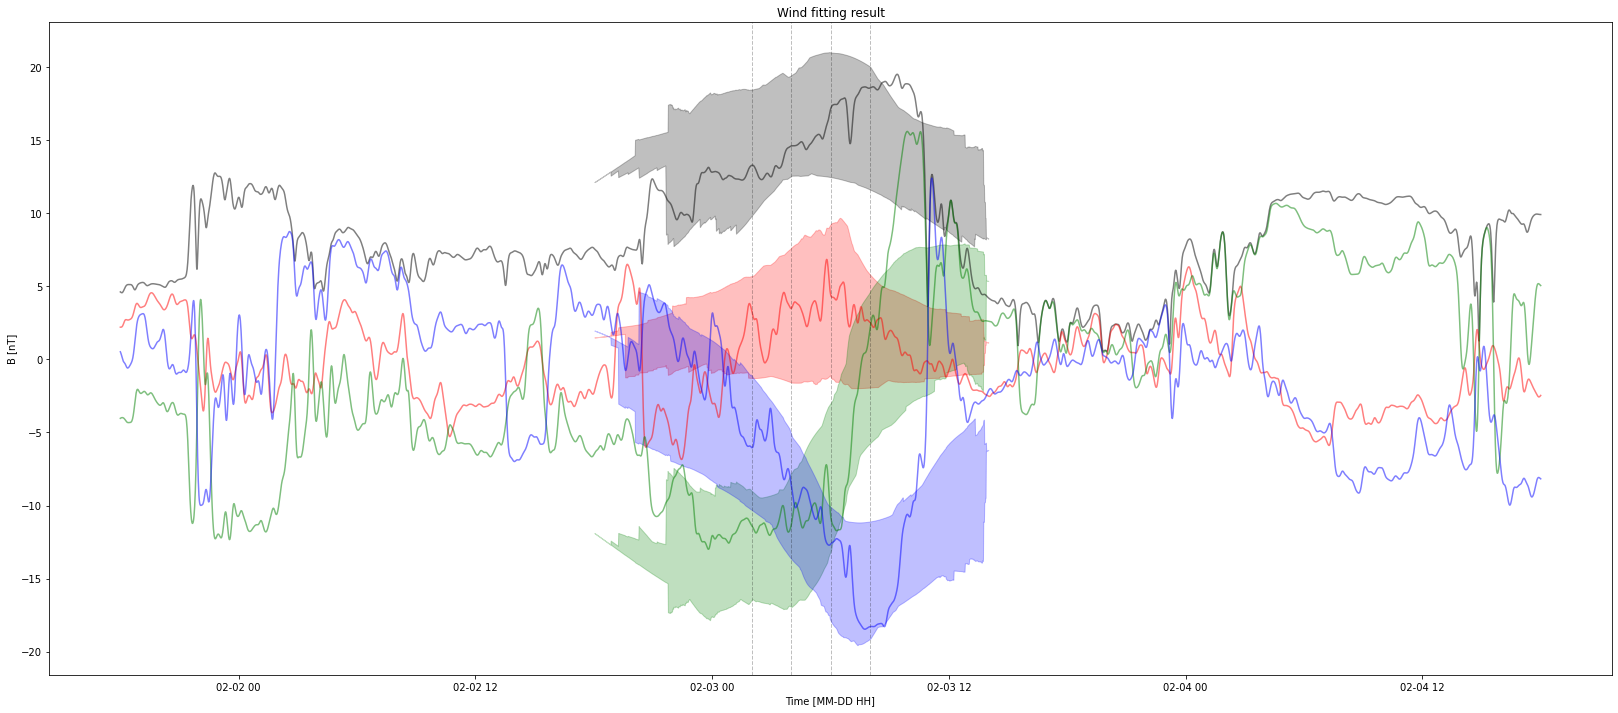

/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:58: RuntimeWarning: Mean of empty slice
  b_m = np.nanmean(ensemble, axis=1)
/home/hruedisser/core91/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:64: RuntimeWarning: Mean of empty slice
  b_tm = np.nanmean(b_t, axis=1)


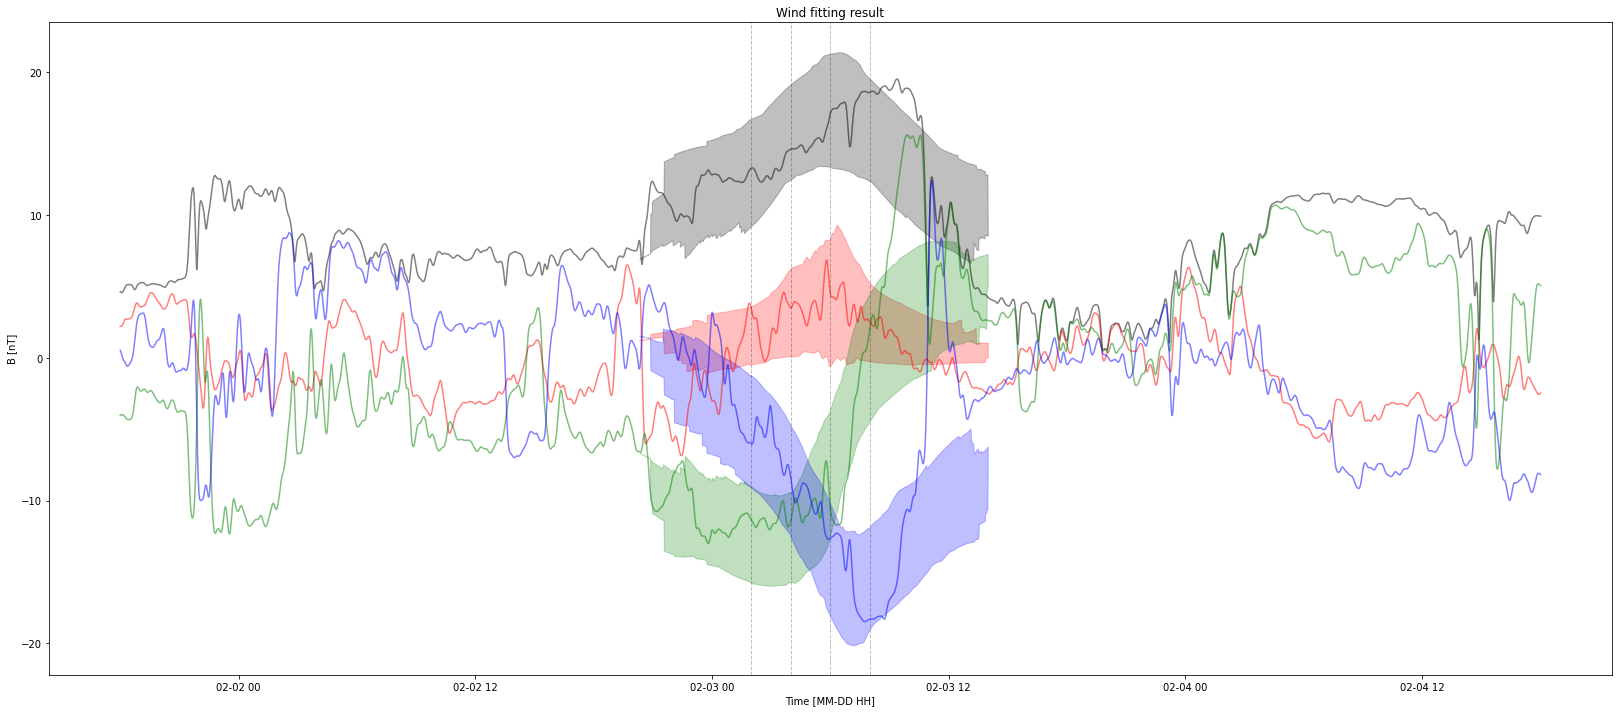

/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:58: RuntimeWarning: Mean of empty slice
  b_m = np.nanmean(ensemble, axis=1)
/home/hruedisser/core91/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:64: RuntimeWarning: Mean of empty slice
  b_tm = np.nanmean(b_t, axis=1)


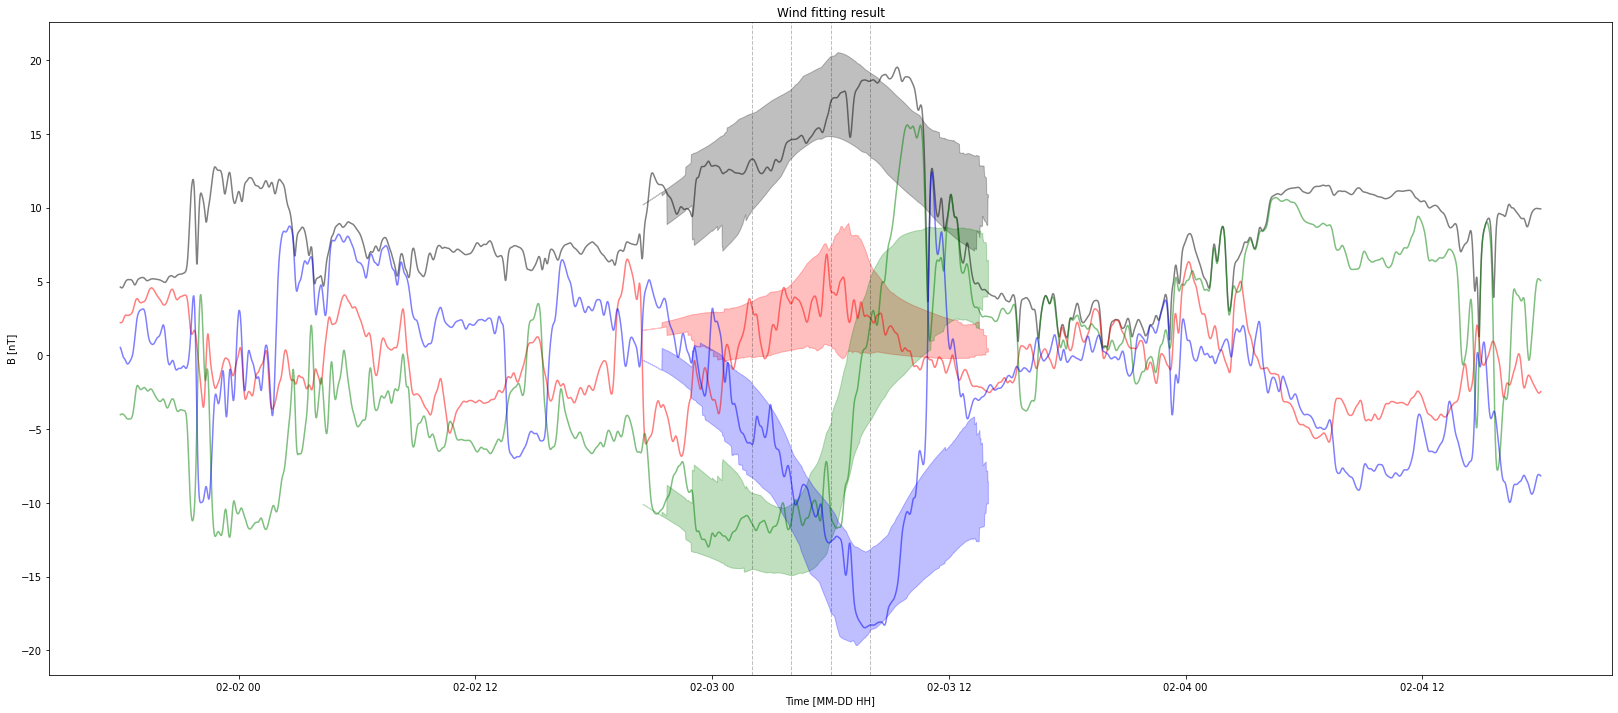

/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:58: RuntimeWarning: Mean of empty slice
  b_m = np.nanmean(ensemble, axis=1)
/home/hruedisser/core91/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:64: RuntimeWarning: Mean of empty slice
  b_tm = np.nanmean(b_t, axis=1)


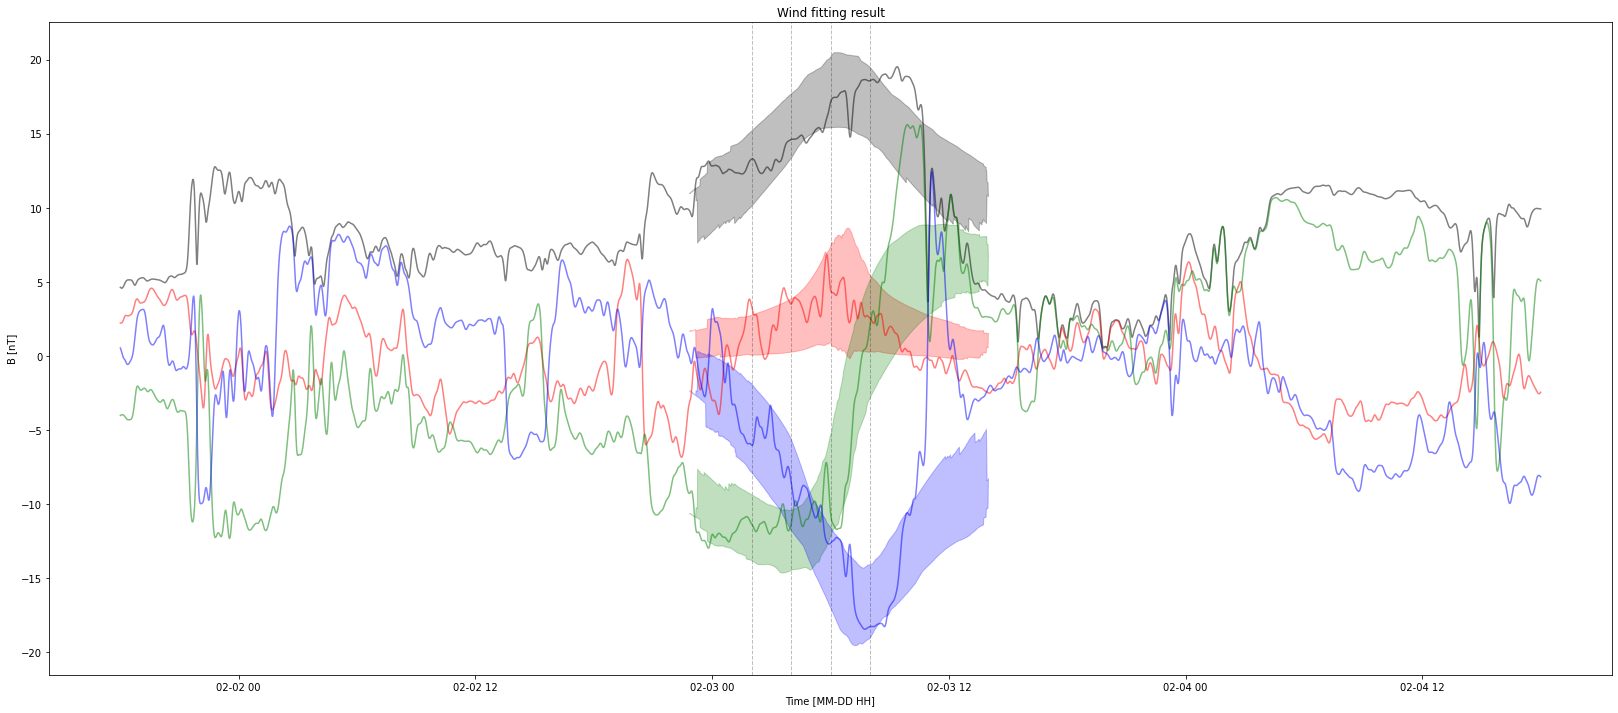

/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:58: RuntimeWarning: Mean of empty slice
  b_m = np.nanmean(ensemble, axis=1)
/home/hruedisser/core91/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:64: RuntimeWarning: Mean of empty slice
  b_tm = np.nanmean(b_t, axis=1)


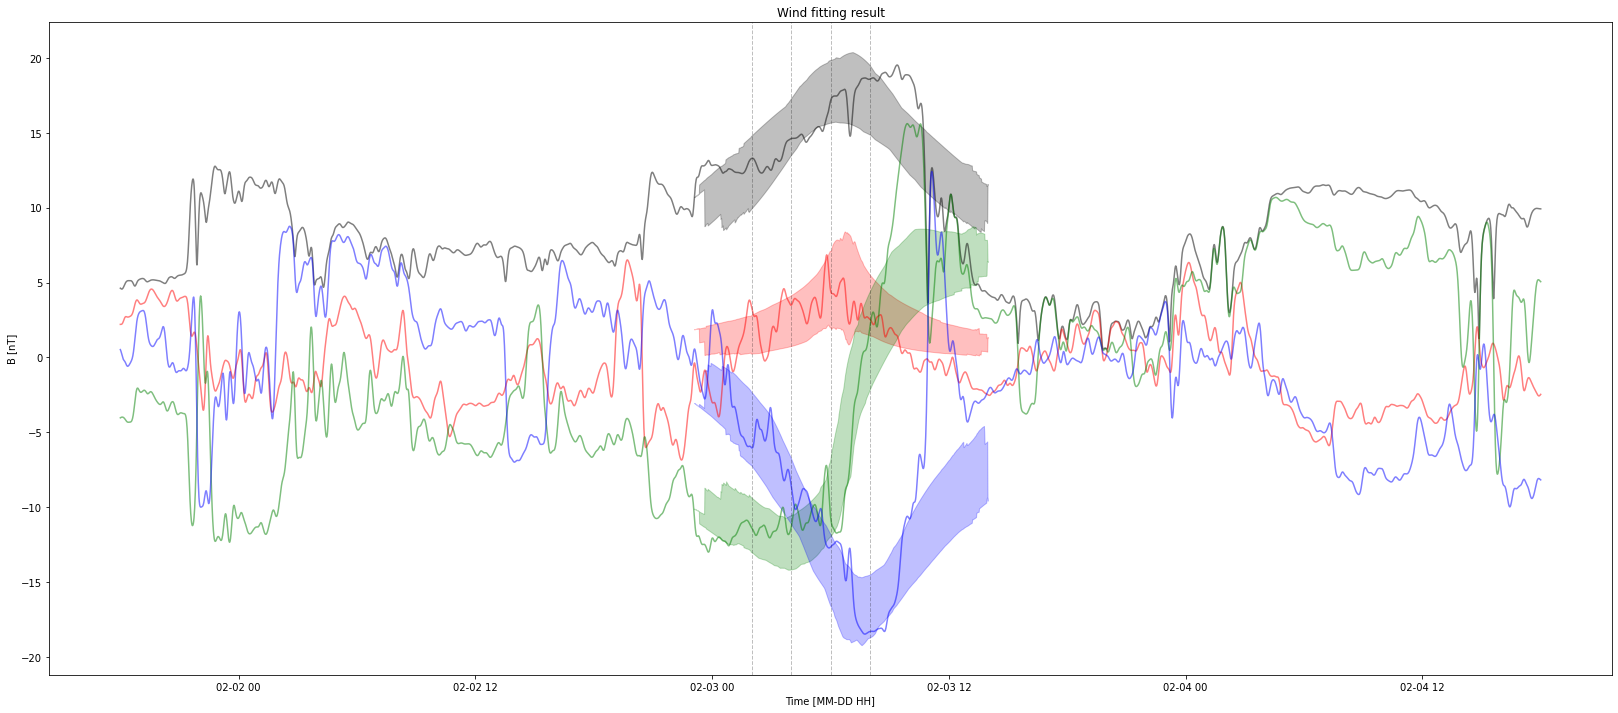

/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:58: RuntimeWarning: Mean of empty slice
  b_m = np.nanmean(ensemble, axis=1)
/home/hruedisser/core91/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/hruedisser/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:64: RuntimeWarning: Mean of empty slice
  b_tm = np.nanmean(b_t, axis=1)


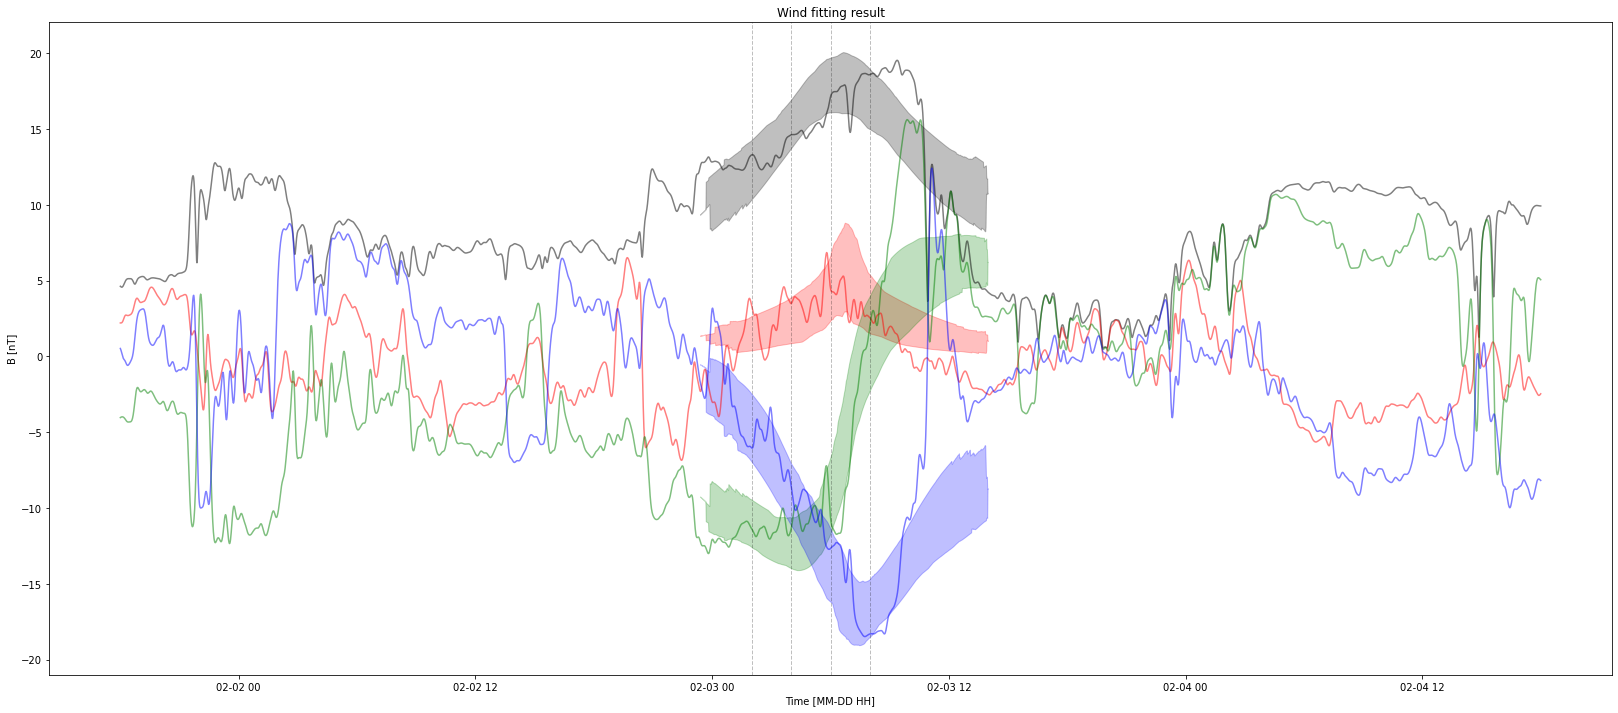

In [10]:
t_s_wind = datetime.datetime(2022, 2, 1, 18, tzinfo=datetime.timezone.utc)
t_e_wind = datetime.datetime(2022, 2, 4, 18,tzinfo=datetime.timezone.utc)

wind_t, wind_b = heliosat.WIND().get([t_s_wind, t_e_wind], "mag", reference_frame="HEEQ", as_endpoints=True, return_datetimes=True, smoothing="gaussian")

for dirl in dir_list:
    
    resultpath = path + dirl
    ed = py3dcore_h4c.generate_ensemble(resultpath, wind_t, reference_frame="HEEQ", reference_frame_to="HEEQ", max_index=128)

    plt.figure(figsize=(28, 12))
    plt.title("Wind fitting result")
    plt.plot(wind_t, np.sqrt(np.sum(wind_b**2, axis=1)), "k", alpha=0.5)
    plt.plot(wind_t, wind_b[:, 0], "r", alpha=0.5)
    plt.plot(wind_t, wind_b[:, 1], "g", alpha=0.5)
    plt.plot(wind_t, wind_b[:, 2], "b", alpha=0.5)
    plt.fill_between(wind_t, ed[0][3][0], ed[0][3][1], alpha=0.25, color="k")
    plt.fill_between(wind_t, ed[0][2][0][:, 0], ed[0][2][1][:, 0], alpha=0.25, color="r")
    plt.fill_between(wind_t, ed[0][2][0][:, 1], ed[0][2][1][:, 1], alpha=0.25, color="g")
    plt.fill_between(wind_t, ed[0][2][0][:, 2], ed[0][2][1][:, 2], alpha=0.25, color="b")
    plt.ylabel("B [nT]")
    plt.xlabel("Time [MM-DD HH]")
    for _ in t_wind:
        plt.axvline(x=_, lw=1, alpha=0.25, color="k", ls="--")
    plt.savefig(path+'%s.png' % dirl)
    plt.show()

In [12]:
file = open(path + dir_list[-1], "rb")
data = pickle.load(file)
file.close()
# overview of what is in data
cnt = 0
for item in data:
    print(item)
    cnt += 1
# save in temp variable    
epses_t = data["epses"]
# get index for minimum eps
ip = np.argmin(epses_t)    
# save in temp variable
model_objt = data["model_obj"]
iparams_arrt = model_objt.iparams_arr
# get parameters for run (=index) with minimum eps
iparams_arrt[ip]

locked
dt_0
model_kwargs
observers
model
iter_i
hist_eps
hist_time
hist_eps_dim
model_obj
data_obj
epses


array([ 0.0000000e+00, -7.1875820e+00, -2.3427608e+01,  6.8166191e+01,
        8.5441403e-02,  2.0793097e+00,  2.0000000e+01,  7.2900244e+02,
        1.0973128e+02,  1.1400000e+00,  1.6400000e+00,  1.6954437e+01,
        1.6839672e+00,  3.0623502e+02], dtype=float32)